# Figuring out most unusual segments (continuous segments)
First let's import the necessary libraries and load the dataset

In [1]:
# this makes the notebook expand to full width of the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/g1/s15bgzz12434wvvk2kcyf8tr0000gq/T/ipykernel_80607/3308931027.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
%%javascript

// turn off scrollable windows for too large output
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

First you need to amend the `sys.path.append` commands below so the notebook can find them.

In [3]:
%load_ext autoreload
%autoreload 2


import os, sys
import datetime
import random
from typing import List
import copy
import gzip

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

root_path = os.path.realpath('../..')
print(root_path)

# this assumes that all of the following files are checked in the same directory
sys.path.append(os.path.join(root_path,"wise-pizza"))

# create data-related directories
data_dir = os.path.realpath(os.path.join(root_path, 'wise-pizza/data'))
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
print(data_dir)

from wise_pizza import explain_levels, explain_changes_in_totals, explain_changes_in_average

# False if you want nice interactive plots
# True if you want static plots (Doesn't work on all platforms yet)
plot_is_static = False

/Users/alexander.polyakov/Desktop
/Users/alexander.polyakov/Desktop/wise-pizza/data


In [4]:
import plotly.io as pio
pio.renderers.default = 'notebook'

We use the dataset from file `synth_data` but you can just change variable `df` to your data

In [5]:
df = pd.read_csv(os.path.join(data_dir, "synth_data.csv"))  # replace this variable with your data
dims = ['TYPE', 'REGION', 'FIRST_PRODUCT', 'CURRENCY']  # dimensions to find segments
totals = 'VOLUME'  # value to analyze
size = 'TRANSACTION_COUNT'  # number of objects

months = sorted(df.COHORT_MONTH.unique())  # unique months in the dataset

data = df[df.COHORT_MONTH == months[-1]]  # take the last month
pre_data = df[df.COHORT_MONTH == months[-2]]  # take the penultimate month

data.tail().T

,17514,17515,17516,17517,17518
COHORT_MONTH,2021-10-01,2021-10-01,2021-10-01,2021-10-01,2021-10-01
TYPE,bank_partnerships,seo_content,affiliates,paid_search,owned_partners
REGION,REGION 5,REGION 7,REGION 4,REGION 3,REGION 4
FIRST_PRODUCT,BANK CARD,ADD MONEY,ADD MONEY,ADD MONEY,BANK CARD
CURRENCY,NOK,EGP,NOK,KGS,BDT
VOLUME,2269.178515,2611.306968,2388.99726,1528.398037,2861.989602
TRANSACTION_COUNT,8,3,48,10,2
VOLUME_STD,266.651533,14.265691,115.158365,220.480347,61.113971


In [6]:
pre_data.head()

,COHORT_MONTH,TYPE,REGION,FIRST_PRODUCT,CURRENCY,VOLUME,TRANSACTION_COUNT,VOLUME_STD
0,2021-09-01,paid_social,REGION 1,BANK CARD,RUB,1559.833336,2,150.390421
1,2021-09-01,seo_content,REGION 2,BANK CARD,MXN,36419.208795,89,677.062999
2,2021-09-01,paid_display,REGION 9,ADD MONEY,CLP,2527.694180,52,377.147204
3,2021-09-01,invite,REGION 3,TRANSFER,LKR,1795.298318,7,267.638630
4,2021-09-01,invite,REGION 2,BANK CARD,RUB,12381.810106,12,1849.385016


### Let's create continuous column for testing (replace with your own)

In [7]:
np.random.seed(42)

continuous_feature = 'SPEND'
pre_data[continuous_feature] = np.random.normal(size=len(pre_data))
data[continuous_feature] = np.random.normal(size=len(data))

In [8]:
data.head()

,COHORT_MONTH,TYPE,REGION,FIRST_PRODUCT,CURRENCY,VOLUME,TRANSACTION_COUNT,VOLUME_STD,SPEND
8742,2021-10-01,seo_content,REGION 3,BANK CARD,CLP,3683.032122,19,430.221154,0.131119
8743,2021-10-01,word_of_mouth,REGION 3,ADD MONEY,AED,445.693107,11,390.889818,0.884843
8744,2021-10-01,affiliates,REGION 2,BANK CARD,CRC,11952.977525,16,1322.486202,2.051247
8745,2021-10-01,invite,REGION 6,TRANSFER,NZD,5428.769821,22,308.485979,-0.693804
8746,2021-10-01,word_of_mouth,REGION 6,BANK CARD,GBP,3550.664541,8,1971.655767,-0.099314


### Transform continuous features into buckets

In [9]:
from optbinning import ContinuousOptimalBinning # binning library

optb = ContinuousOptimalBinning(name=continuous_feature, dtype="numerical")

optb.fit(data[continuous_feature], data[totals], sample_weight = data[size]) # fit for specific column based on target and sizes as weights

data[continuous_feature + '_TRANSFORMED'] = optb.transform(data[continuous_feature], metric="bins") # continuous -> bins

(CVXPY) Feb 02 06:29:46 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 02 06:29:46 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [10]:
data.head()

,COHORT_MONTH,TYPE,REGION,FIRST_PRODUCT,CURRENCY,VOLUME,TRANSACTION_COUNT,VOLUME_STD,SPEND,SPEND_TRANSFORMED
8742,2021-10-01,seo_content,REGION 3,BANK CARD,CLP,3683.032122,19,430.221154,0.131119,"[-0.21, 0.65)"
8743,2021-10-01,word_of_mouth,REGION 3,ADD MONEY,AED,445.693107,11,390.889818,0.884843,"[0.65, 1.47)"
8744,2021-10-01,affiliates,REGION 2,BANK CARD,CRC,11952.977525,16,1322.486202,2.051247,"[1.47, inf)"
8745,2021-10-01,invite,REGION 6,TRANSFER,NZD,5428.769821,22,308.485979,-0.693804,"[-0.78, -0.34)"
8746,2021-10-01,word_of_mouth,REGION 6,BANK CARD,GBP,3550.664541,8,1971.655767,-0.099314,"[-0.21, 0.65)"


# Finding the juiciest slices
Now let's look for segments where the average value ( defined as segment total divided by segment size ) is most different from the overall average. 

**explain_levels**: Find segments whose average is most different from the global one

- `df`: Dataset
- `dims`: List of discrete dimensions
- `total_name`: Name of column that contains totals per segment
- `size_name`: Name of column containing segment sizes
- `min_segments`: Minimum number of segments to find
- `max_segments`: Maximum number of segments to find, defaults to min_segments
- `min_depth`: Minimum number of dimension to constrain in segment definition
- `max_depth`: Maximum number of dimension to constrain in segment definition
- `solver`: If this equals to "lp" uses the LP solver, else uses the (recommended) Lasso solver
    - `"lasso"`: Lasso-based finder of unusual segments
    - `"lp"`: LP-based finder of unusual segments
- `cluster_values`: In addition to single-value slices, consider slices that consist of a
    group of segments from the same dimension with similar naive averages
    - `True`: to use cluster values, you can them using `sf.relevant_cluster_names`
    - `False`: to use simple segments
- `verbose`: If set to a truish value, lots of debug info is printed to console, also you can check progressbar
    - `True`: to get info
    - `False`: to get result without info
    
    
- Use `.plot()` to see the plot after fitting:
    - `plot_is_static`: static (True) or dynamic (False) plotly result
        - `True`: to get static plots (Doesn't work on all platforms yet)
        - `False`: to get dynamic plots
    - `width`: to change the width of the plot
    - `height`: to change the height of the plot
    
    
- Use `.segments` to see the values after fitting

In [11]:
dims = ['TYPE', 'REGION', 'FIRST_PRODUCT', 'CURRENCY'] + [continuous_feature + '_TRANSFORMED']  # dimensions to find segments

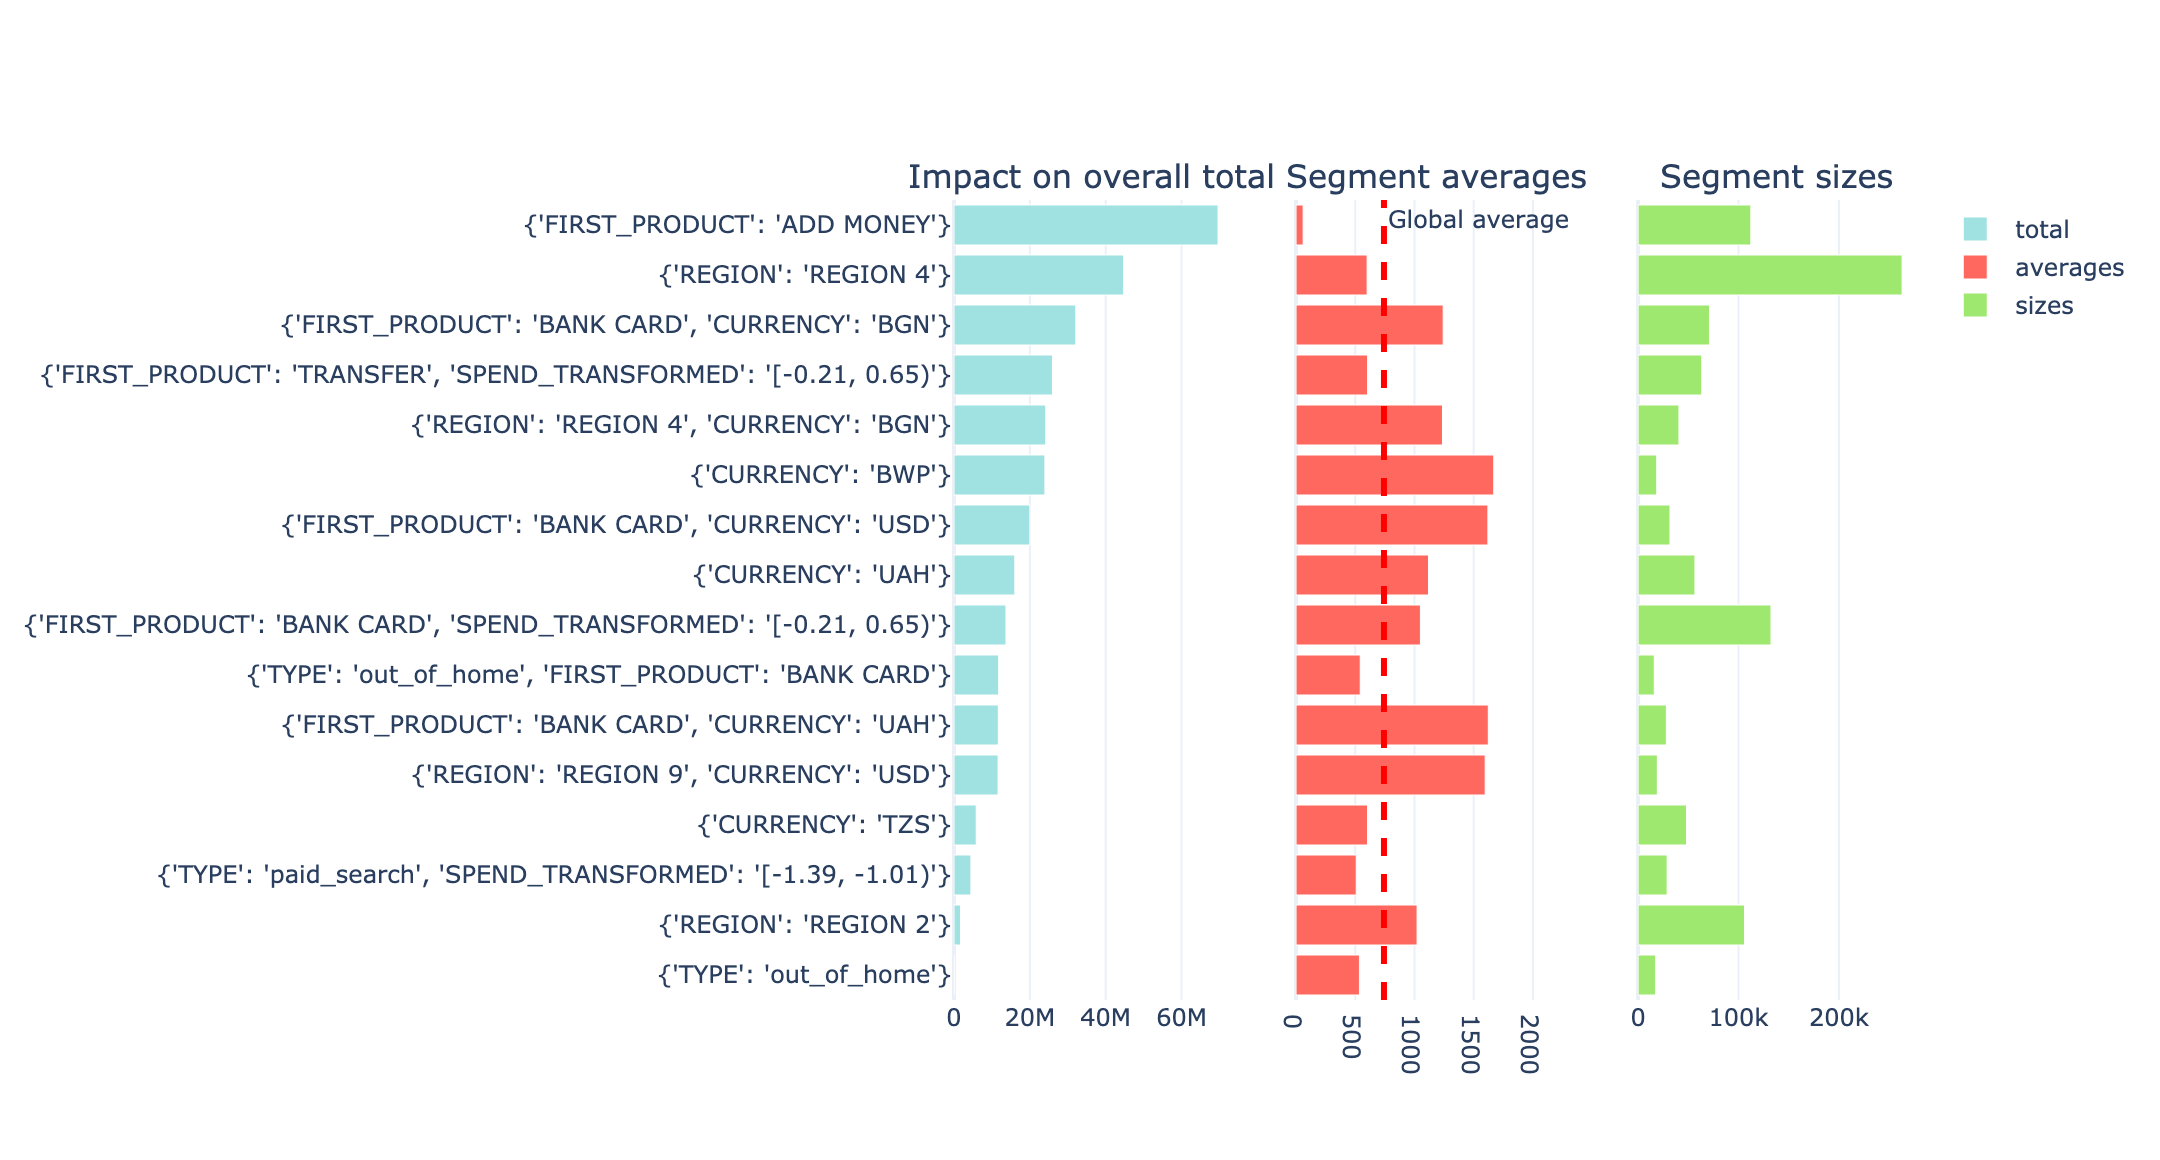

In [12]:
sf = explain_levels(
    df=data,
    dims=dims,
    total_name=totals,
    size_name=size,
    max_depth=2,
    min_segments=20,
    solver="lasso"
)
sf.plot(width=600, height=100, plot_is_static=plot_is_static)

# Analyzing differences
Next, let's look for segments that experience the largest *change* in the totals from previous period. A nice utility function, `diff_dataset` creates a dataset with the differences (aligning the segments from the two periods).

**explain_changes_in_totals**: Find segments most useful in explaining the difference between two datasets

- `df1`: First dataset
- `df2`: Second dataset
- `dims`: List of discrete dimensions
- `total_name`: Name of column that contains totals per segment
- `size_name`: Name of column containing segment sizes
- `min_segments`: Minimum number of segments to find
- `max_segments`: Maximum number of segments to find, defaults to min_segments
- `min_depth`: Minimum number of dimension to constrain in segment definition
- `max_depth`: Maximum number of dimension to constrain in segment definition
- `solver`: If this equals to "lp" uses the LP solver, else uses the (recommended) Lasso solver 
    - `"lasso"`: Lasso-based finder of unusual segments
    - `"lp"`: LP-based finder of unusual segments
- `cluster_values`: In addition to single-value slices, consider slices that consist of a
    group of segments from the same dimension with similar naive averages
    - `True`: to use cluster values, you can them using `sf.relevant_cluster_names`
    - `False`: to use simple segments
- `how`:
    - `"totals"`: to only decompose segment totals (ignoring size vs average contribution)
    - `"split_fits"`: to separately decompose contribution of size changes and average changes
    - `"extra_dim"`: to treat size vs average change contribution as an additional dimension
    - `"force_dim"`: like extra_dim, but each segment must contain a Change_from constraint
- `verbose`: If set to a truish value, lots of debug info is printed to console, also you can check progressbar
    - `True`: to get info
    - `False`: to get result without info
    
    
- Use `.plot()` to see the plot after fitting:
    - `plot_is_static`: static (True) or dynamic (False) plotly result
        - `True`: to get static plots (Doesn't work on all platforms yet)
        - `False`: to get dynamic plots
    - `width`: to change the width of the plot
    - `height`: to change the height of the plot
    
    
- Use `.segments` to see the values after fitting

### Transform continuous features into buckets for two datasets

In [13]:
optb = ContinuousOptimalBinning(name=continuous_feature, dtype="numerical")

fit_data_feature = pd.concat([pre_data[continuous_feature], data[continuous_feature]], ignore_index=True)
fit_data_totals = pd.concat([pre_data[totals], data[totals]], ignore_index=True)
fit_data_size = pd.concat([pre_data[size], data[size]], ignore_index=True)

optb.fit( # fit for specific column based on target and sizes as weights
    fit_data_feature,
    fit_data_totals,
    sample_weight = fit_data_size
)

pre_data[continuous_feature + '_TRANSFORMED'] = optb.transform(pre_data[continuous_feature], metric="bins") # continuous -> bins
data[continuous_feature + '_TRANSFORMED'] = optb.transform(data[continuous_feature], metric="bins") # continuous -> bins

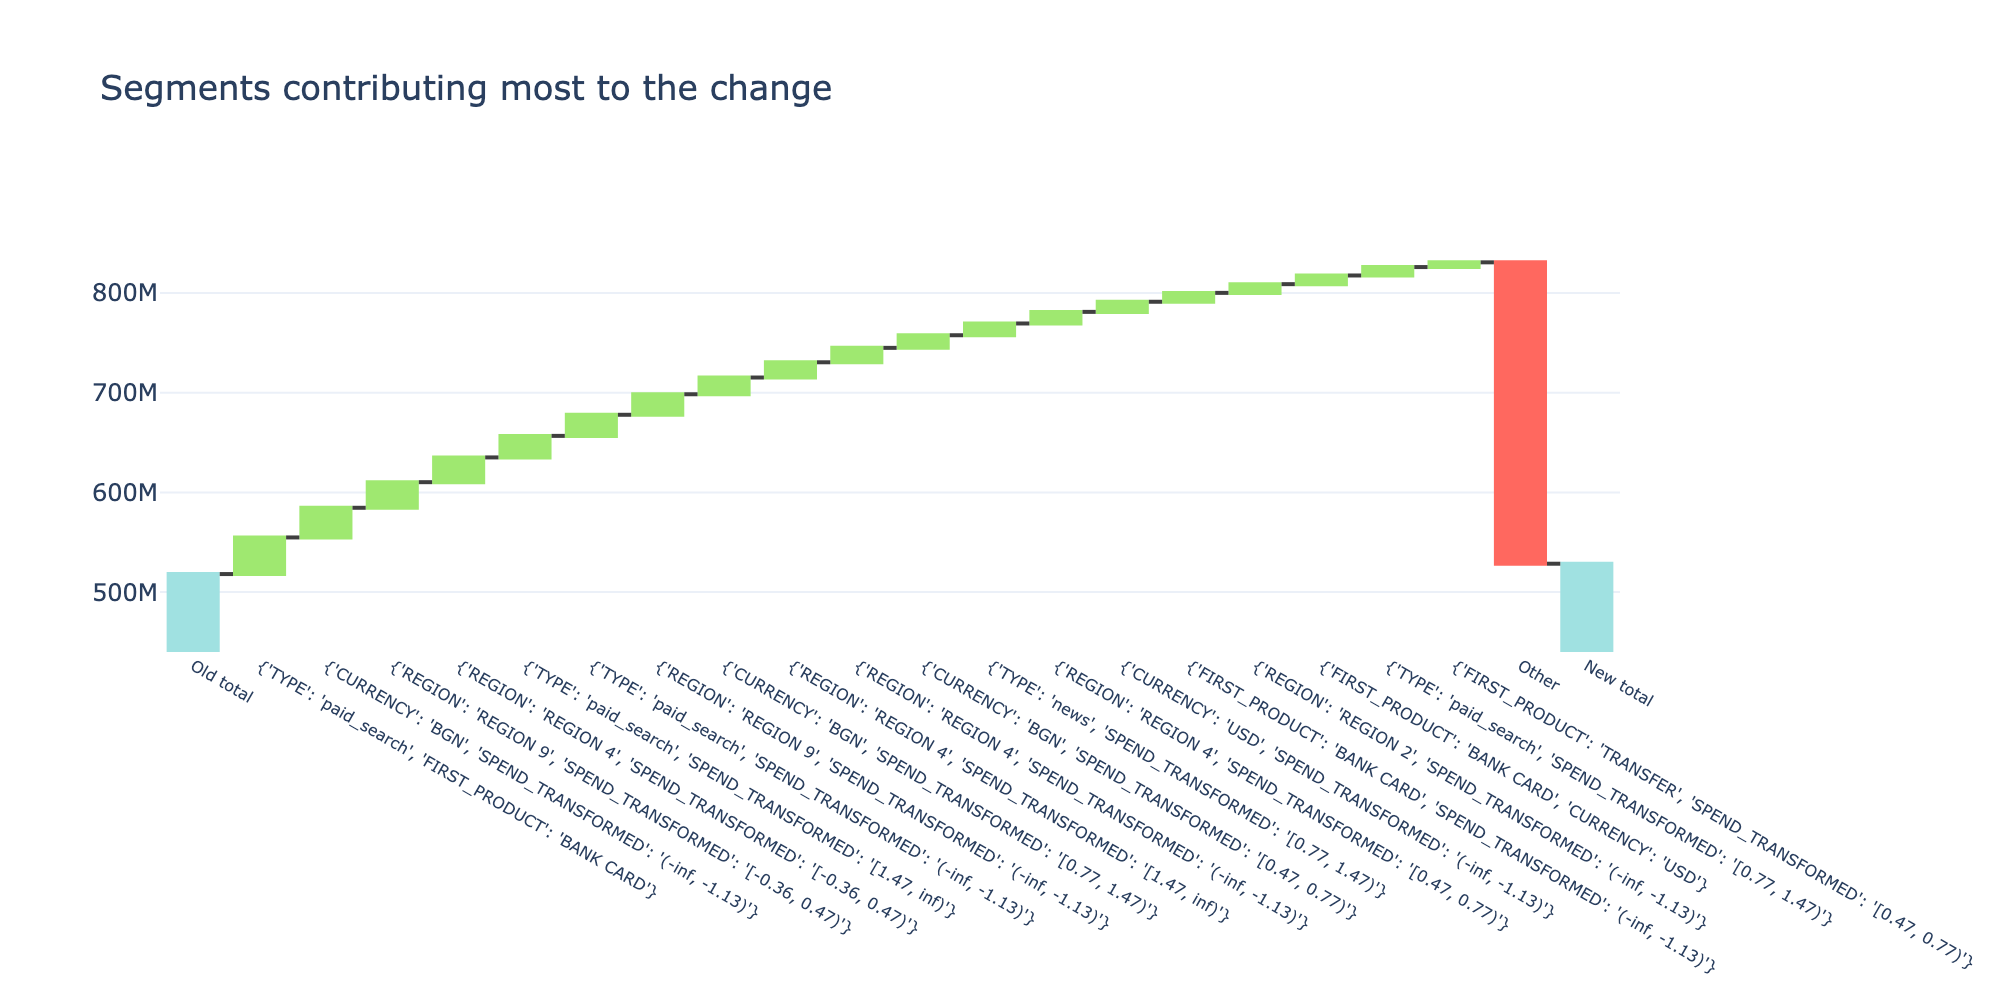

In [14]:
sf1 = explain_changes_in_totals(
    df1=pre_data,
    df2=data,
    dims=dims,
    total_name=totals,
    size_name=size,
    max_depth=2,
    min_segments=20,
    how="totals",
    solver="lasso"
)
sf1.plot(width=1000, height=500, plot_is_static=plot_is_static)

# Decomposing differences
`split_fits` to separately decompose contribution of size changes and average changes

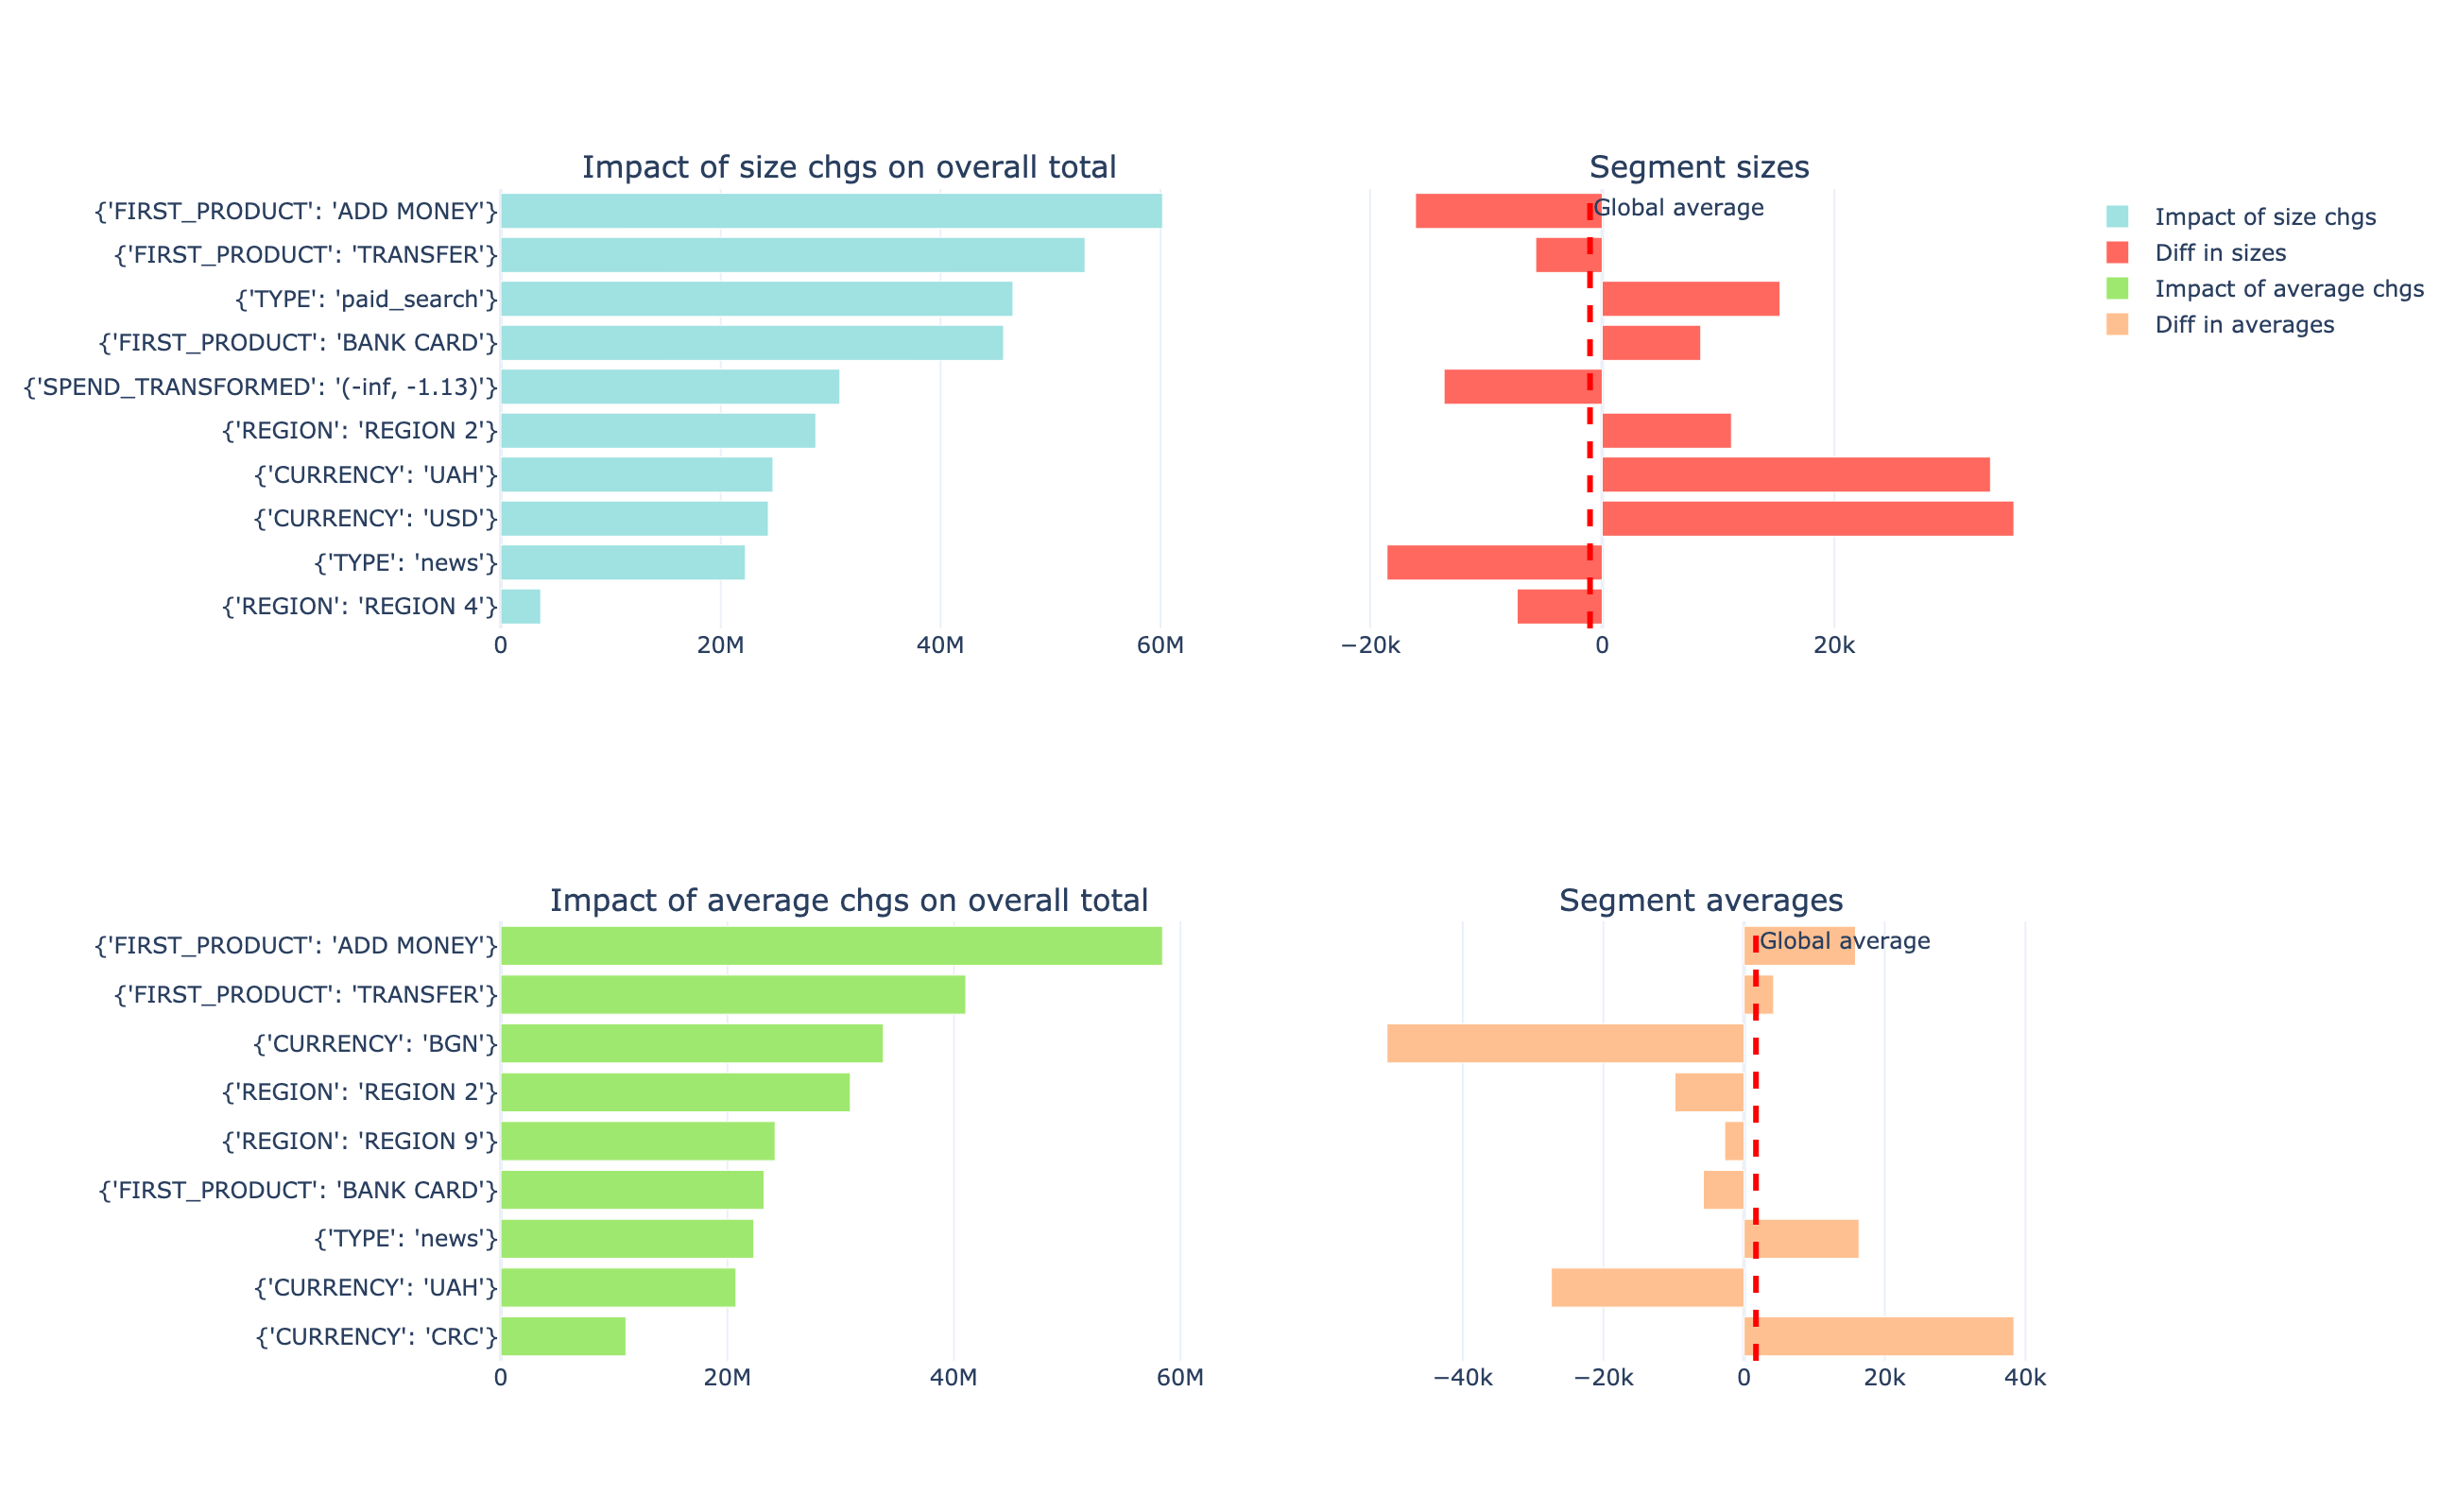

In [15]:
sf2 = explain_changes_in_totals(
    df1=pre_data,
    df2=data,
    dims=dims,
    total_name=totals,
    size_name=size,
    max_depth=1,
    min_segments=10,
    how="split_fits",
    solver="lasso"
)
sf2.plot(width=1000, height=500, plot_is_static=plot_is_static)

`extra_dim` to treat size vs average change contribution as an additional dimension

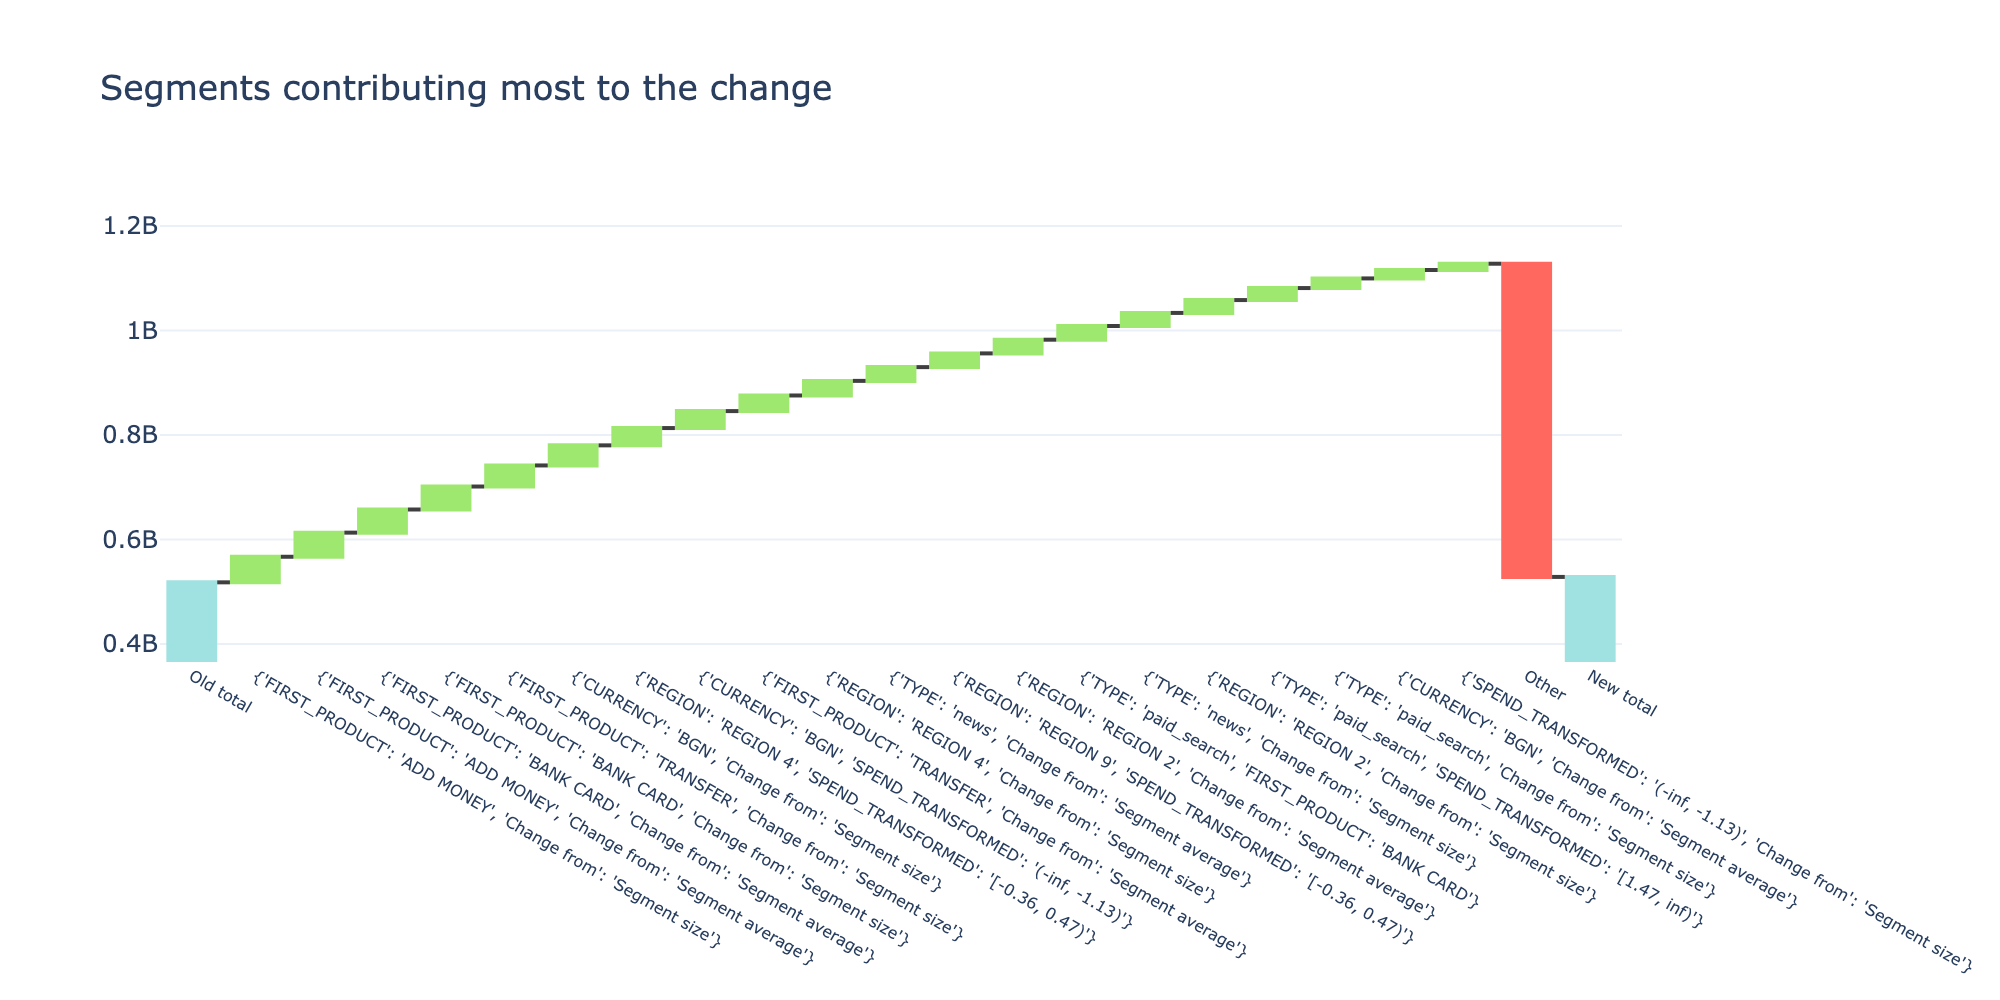

In [16]:
sf3 = explain_changes_in_totals(
    df1=pre_data,
    df2=data,
    dims=dims,
    total_name=totals,
    size_name=size,
    max_depth=2,
    min_segments=20,
    how="extra_dim",
    solver="lasso"
)
sf3.plot(width=1000, height=500, plot_is_static=plot_is_static)

`force_dim` like extra_dim, but each segment must contain a Change_from constraint

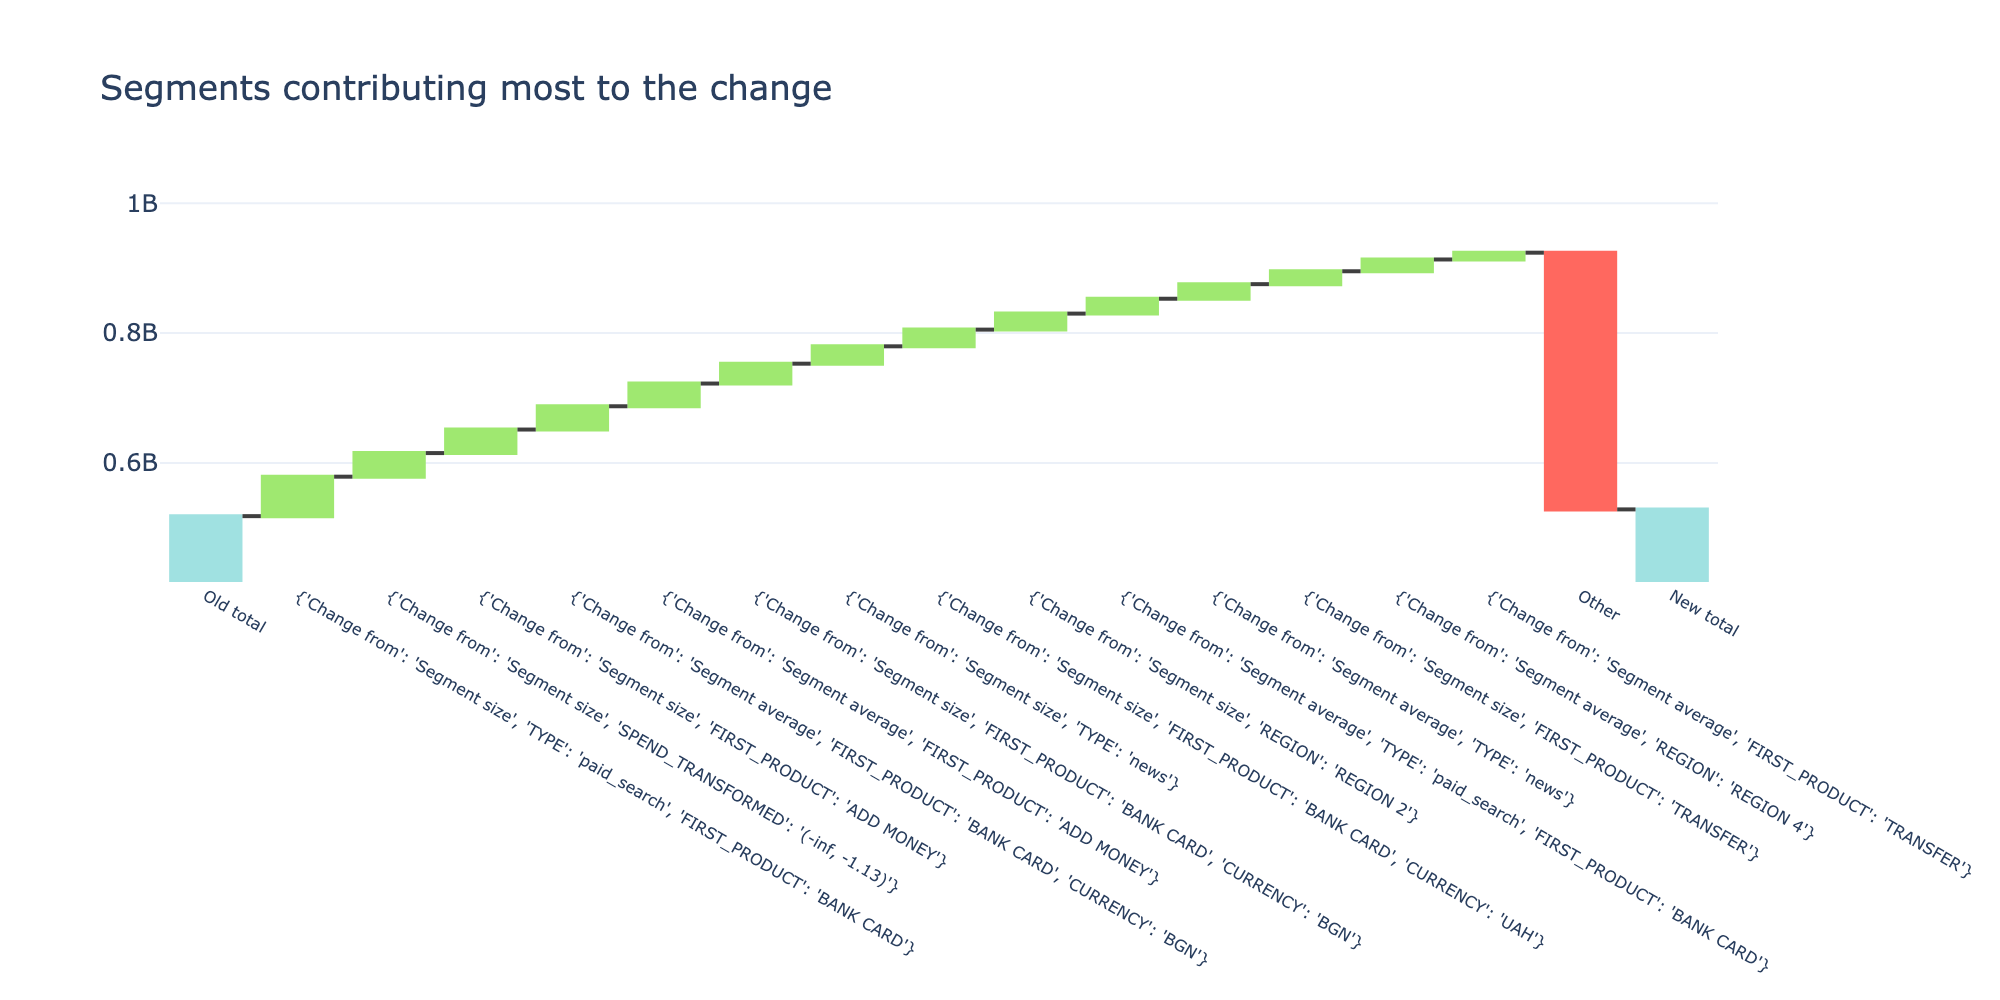

In [17]:
sf3 = explain_changes_in_totals(
    df1=pre_data,
    df2=data,
    dims=dims,
    total_name=totals,
    size_name=size,
    max_depth=2,
    min_segments=15,
    how="force_dim",
    solver="lasso"
)
sf3.plot(width=1000, height=500, plot_is_static=plot_is_static)

# Explaining changes in average

Sometimes, rather than explaining the change in totals from one period to the next, one wishes to explain a change in averages. The analytics of this are a little different - for example, while (as long as all weights and totals are positive) increasing a segment size (other things remaining equal) always increases the overall total, it can increase or decrease the pverall average, depending on whether the average value of that segment is below or above the overall average.


- `df1`: First dataset
- `df2`: Second dataset
- `dims`: List of discrete dimensions
- `total_name`: Name of column that contains totals per segment
- `size_name`: Name of column containing segment sizes
- `min_segments`: Minimum number of segments to find
- `max_segments`: Maximum number of segments to find, defaults to min_segments
- `min_depth`: Minimum number of dimension to constrain in segment definition
- `max_depth`: Maximum number of dimension to constrain in segment definition
- `solver`: If this equals to "lp" uses the LP solver, else uses the (recommended) Lasso solver 
    - `"lasso"`: Lasso-based finder of unusual segments
    - `"lp"`: LP-based finder of unusual segments
- `cluster_values`: In addition to single-value slices, consider slices that consist of a
    group of segments from the same dimension with similar naive averages
    - `True`: to use cluster values, you can them using `sf.relevant_cluster_names`
    - `False`: to use simple segments
- `how`:
    - `"totals"`: to only decompose segment totals (ignoring size vs average contribution)
    - `"split_fits"`: to separately decompose contribution of size changes and average changes
    - `"extra_dim"`: to treat size vs average change contribution as an additional dimension
    - `"force_dim"`: like extra_dim, but each segment must contain a Change_from constraint
- `verbose`: If set to a truish value, lots of debug info is printed to console, also you can check progressbar
    - `True`: to get info
    - `False`: to get result without info
    
    
- Use `.plot()` to see the plot after fitting:
    - `plot_is_static`: static (True) or dynamic (False) plotly result
        - `True`: to get static plots (Doesn't work on all platforms yet)
        - `False`: to get dynamic plots
    - `width`: to change the width of the plot
    - `height`: to change the height of the plot
    
    
- Use `.segments` to see the values after fitting

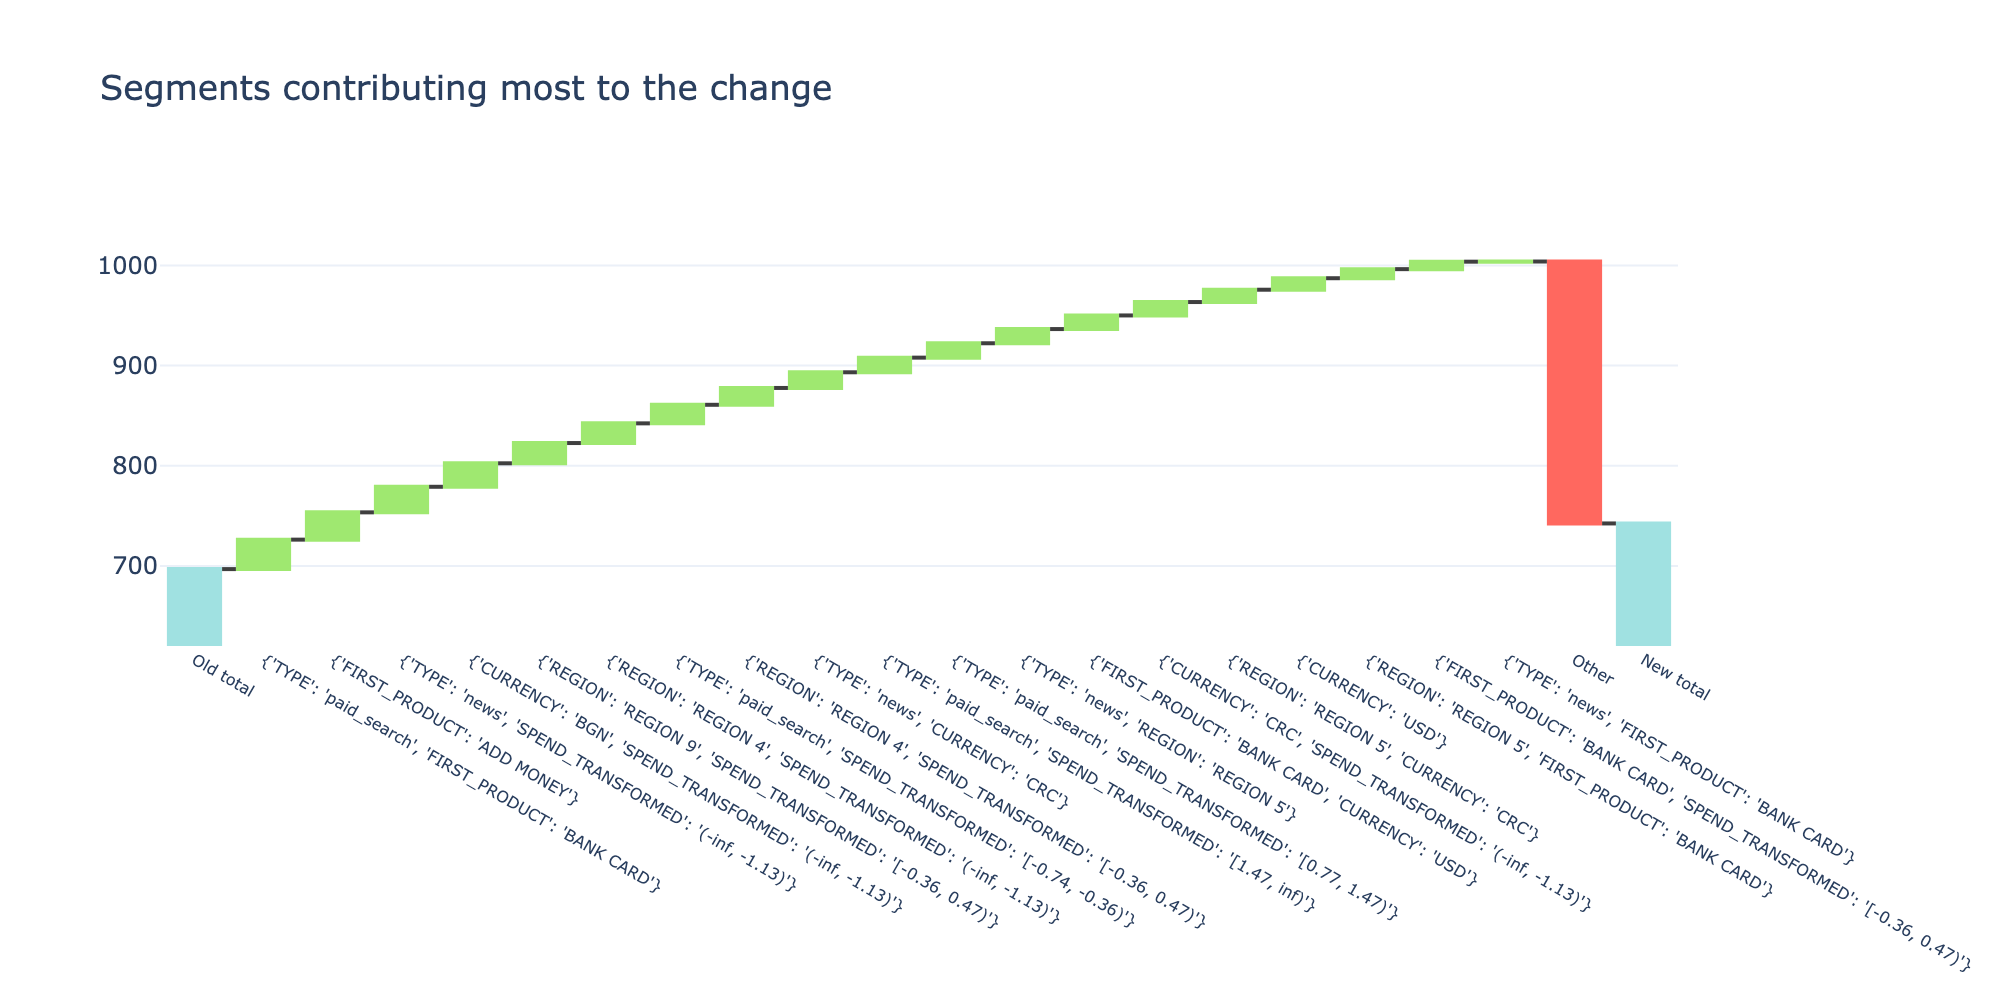

In [18]:
sf4 = explain_changes_in_average(
    df1=pre_data,
    df2=data,
    dims=dims,
    total_name=totals,
    size_name=size,
    max_depth=2,
    min_segments=20,
    how="totals",
    solver="lasso"
)
sf4.plot(width=1000, height=500, plot_is_static=plot_is_static)

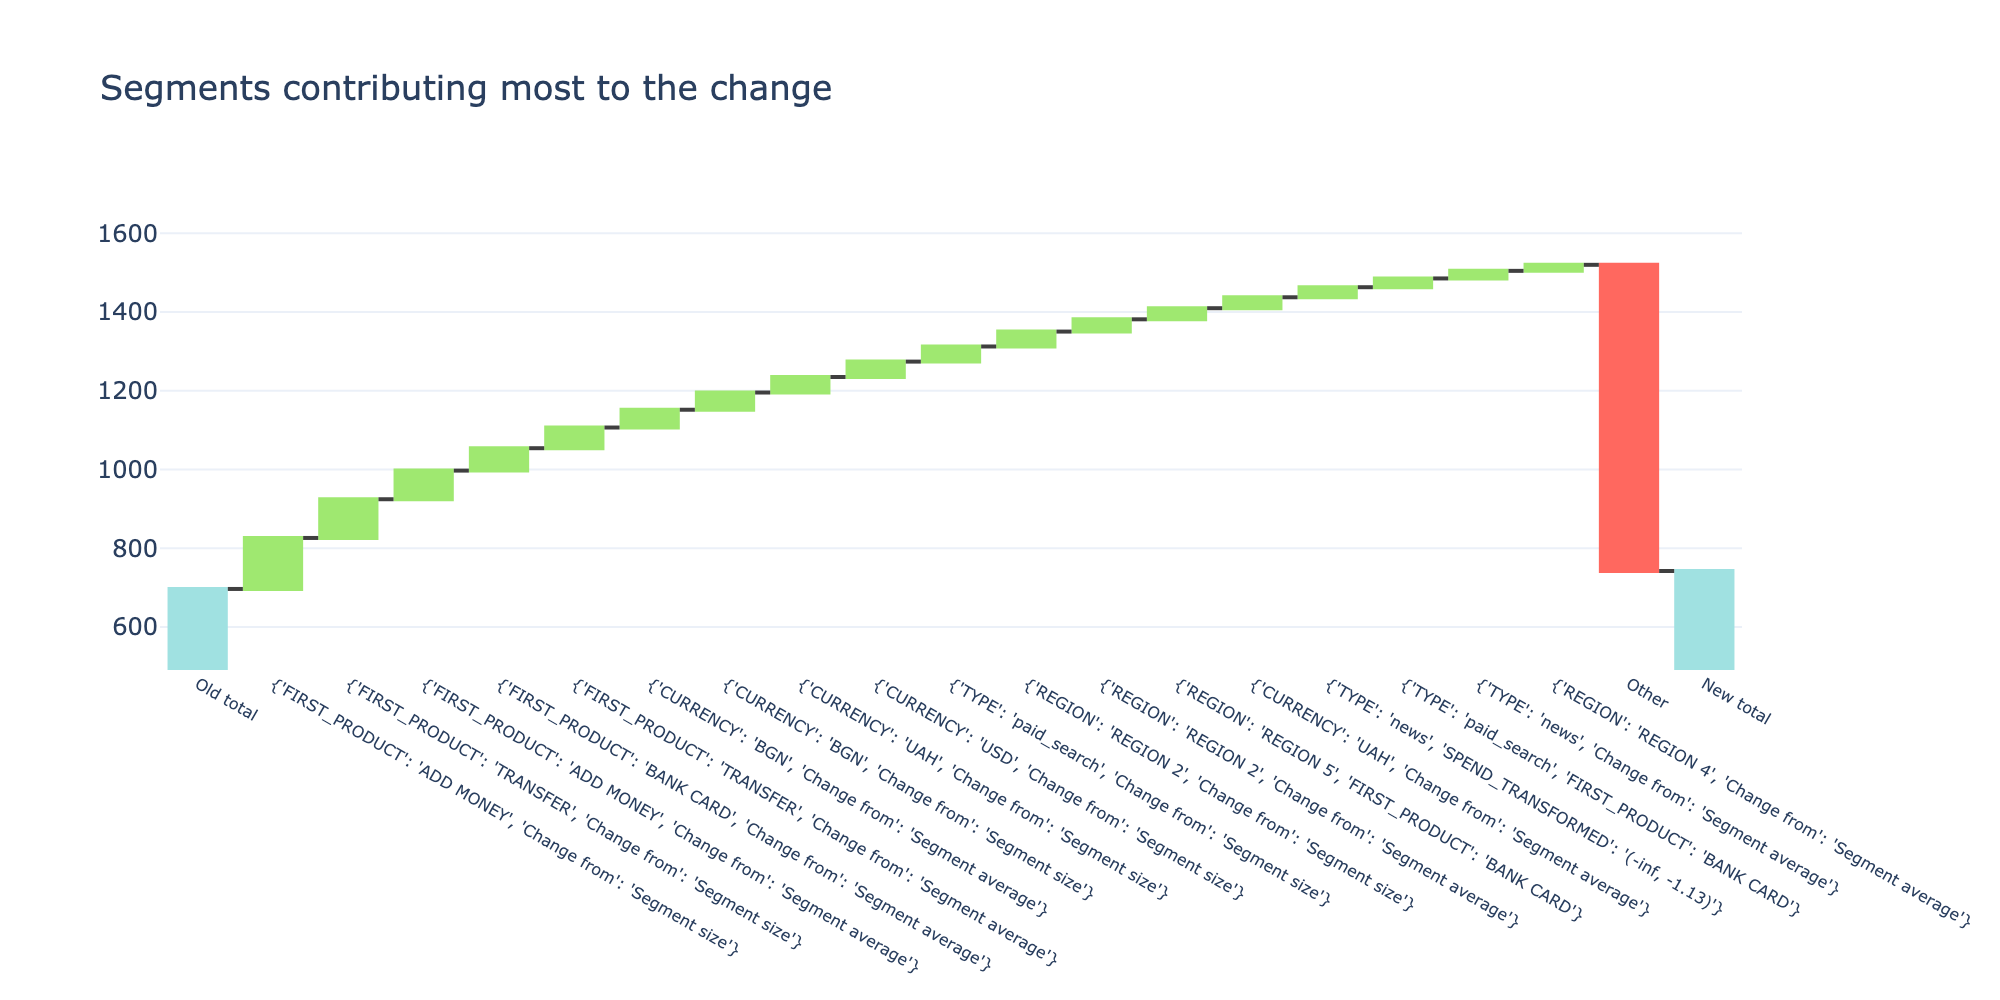

In [19]:
sf5 = explain_changes_in_average(
    df1=pre_data,
    df2=data,
    dims=dims,
    total_name=totals,
    size_name=size,
    max_depth=2,
    min_segments=20,
    how="extra_dim",
    solver="lasso"
)
sf5.plot(width=1000, height=500, plot_is_static=plot_is_static)

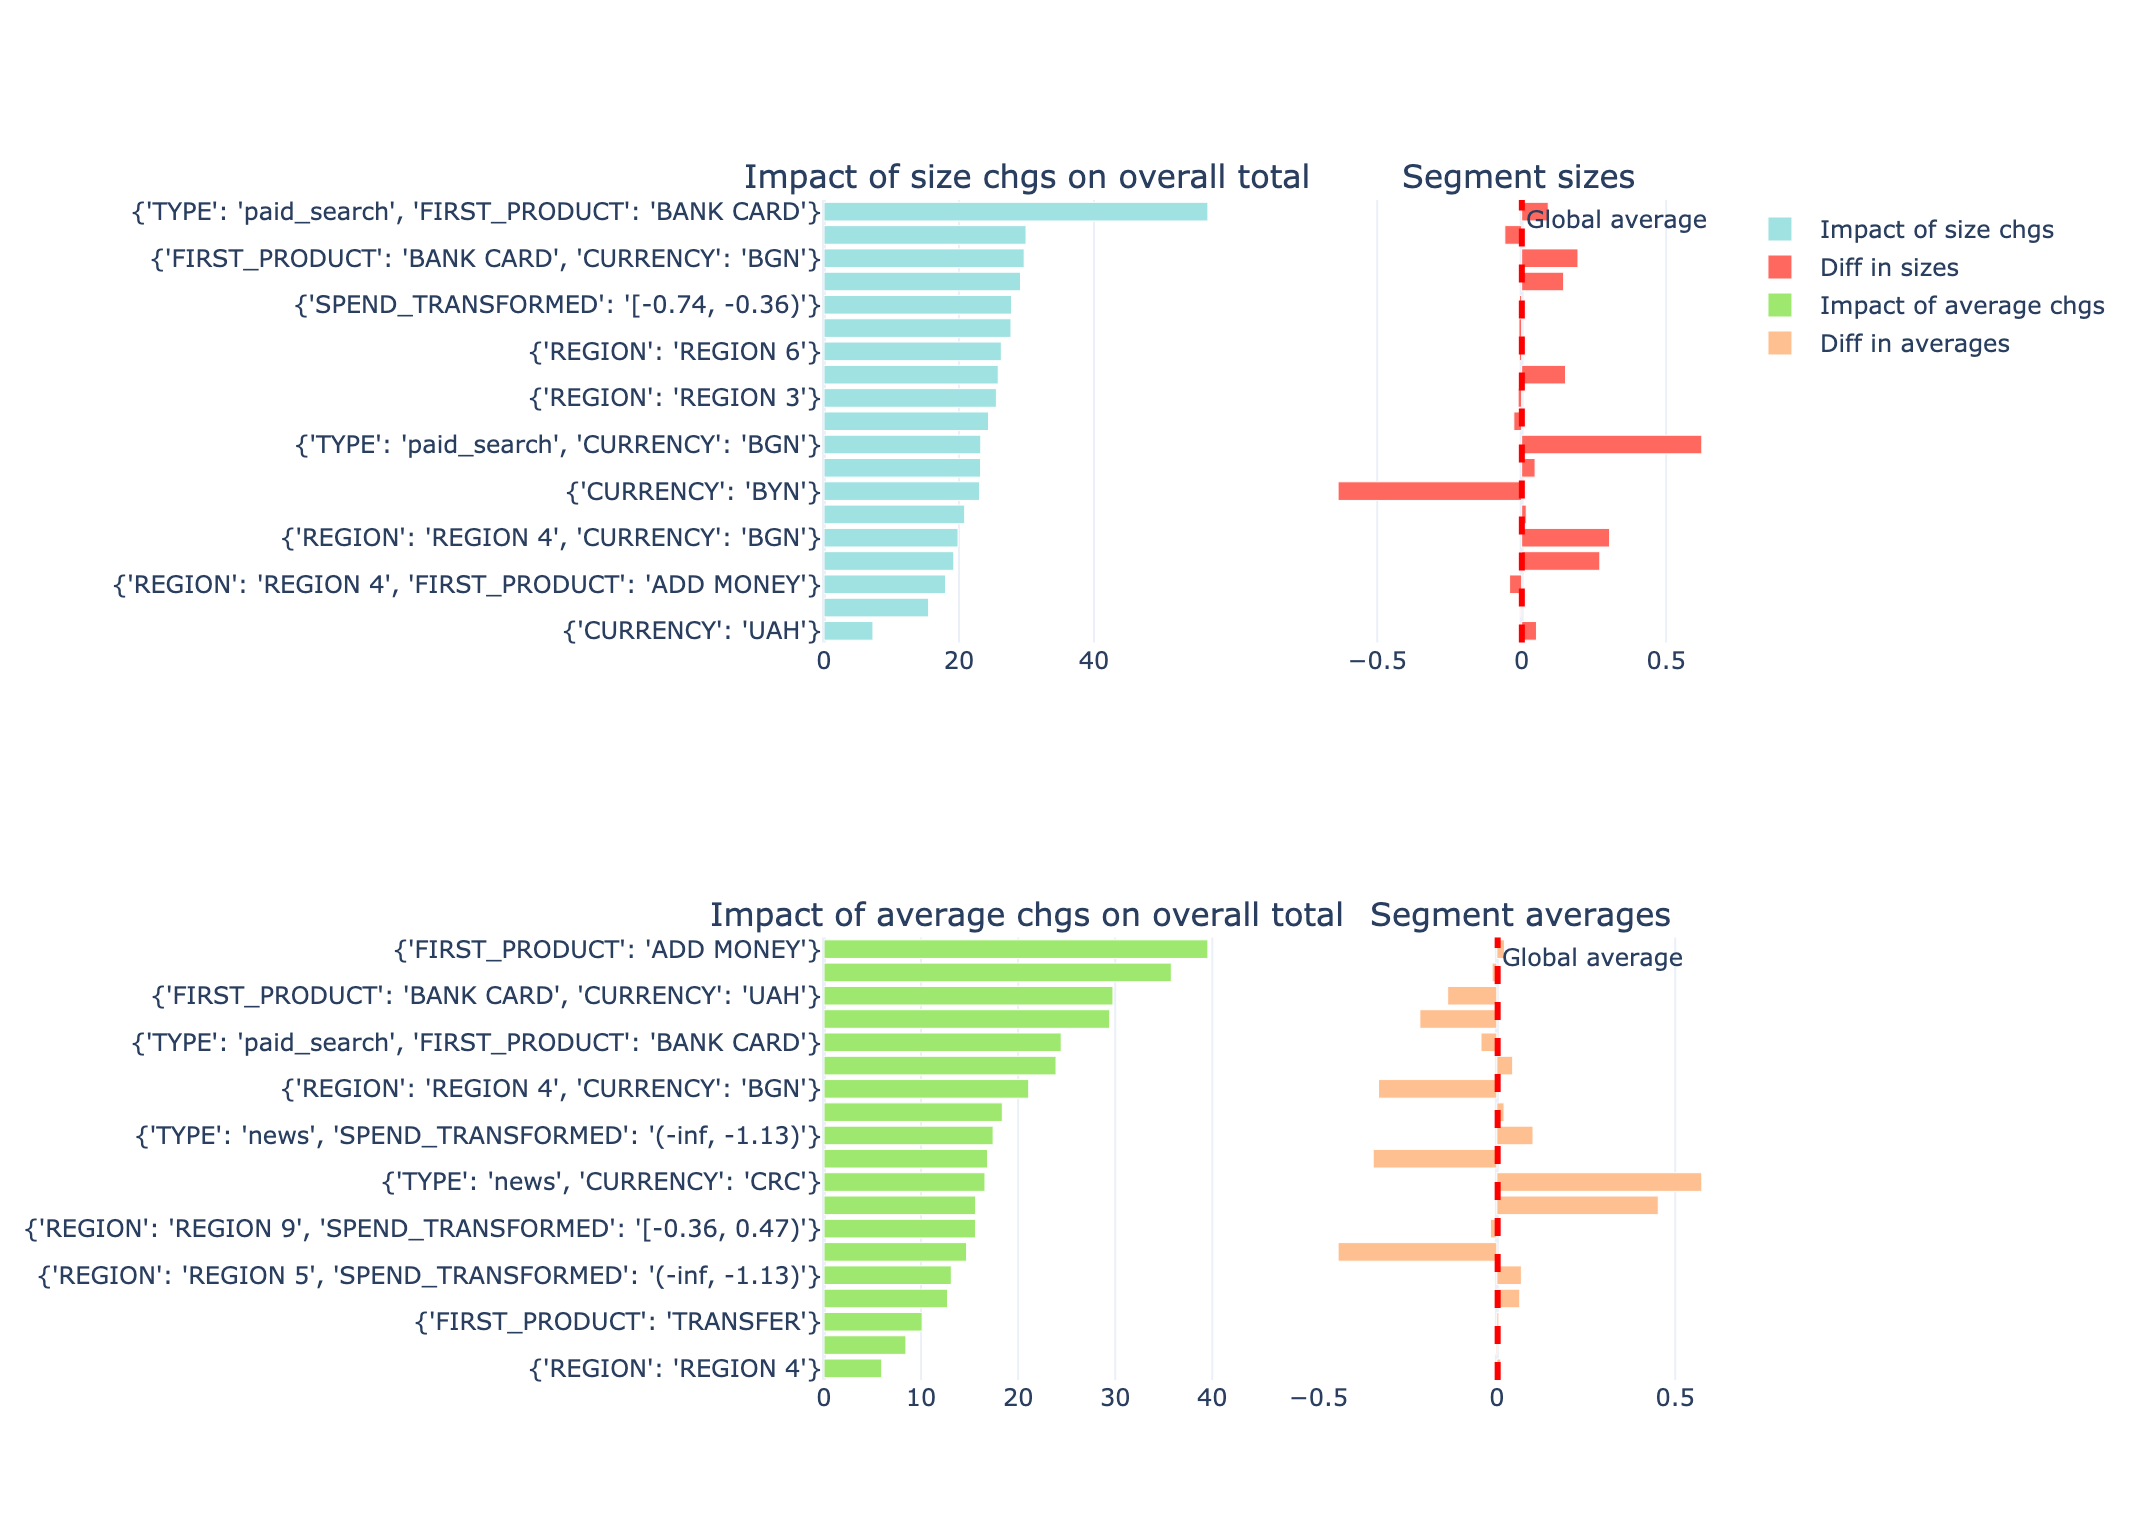

In [20]:
sf6 = explain_changes_in_average(
    df1=pre_data,
    df2=data,
    dims=dims,
    total_name=totals,
    size_name=size,
    max_depth=2,
    min_segments=20,
    how="split_fits",
    solver="lasso"
)
sf6.plot(width=500, height=200, plot_is_static=plot_is_static)

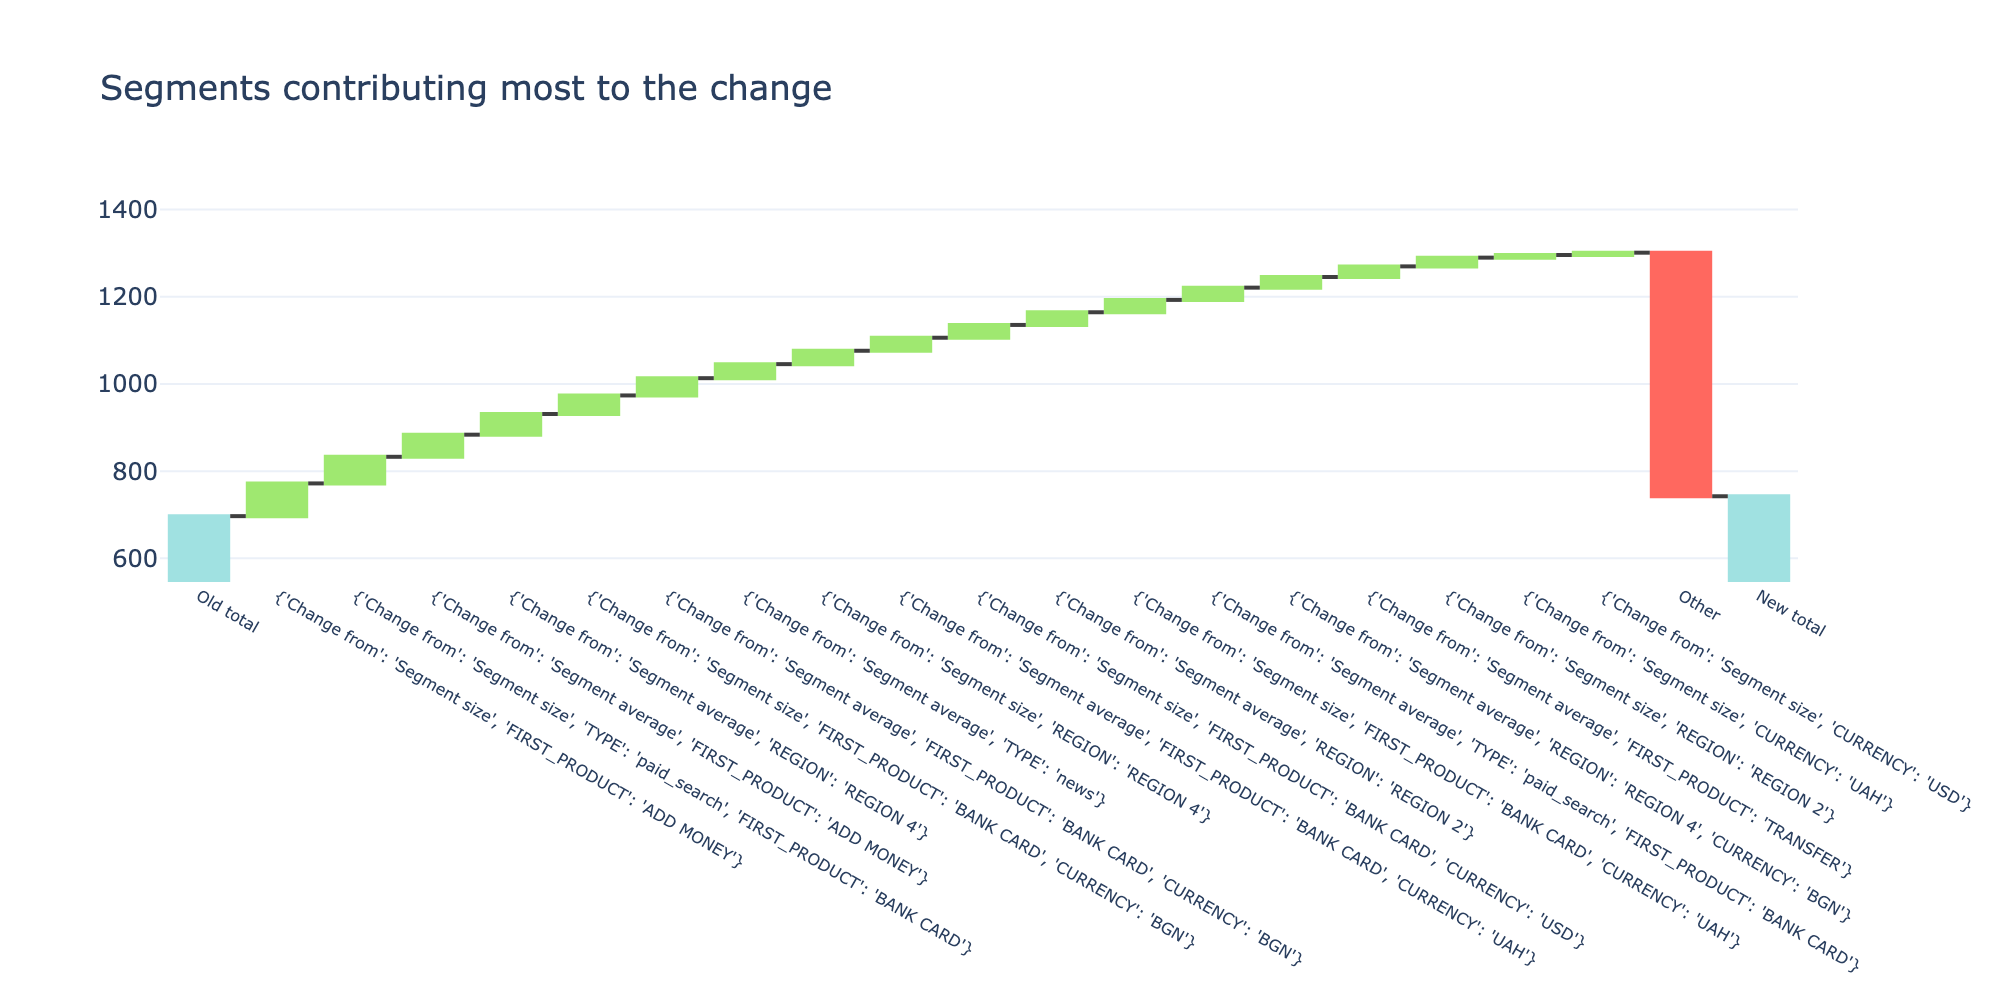

In [21]:
sf7 = explain_changes_in_average(
    df1=pre_data,
    df2=data,
    dims=dims,
    total_name=totals,
    size_name=size,
    max_depth=2,
    min_segments=20,
    how="force_dim",
    solver="lasso"
)
sf7.plot(width=1000, height=500, plot_is_static=plot_is_static)